# Music Emotion Recognition Model Visualization

This notebook contains comprehensive visualizations for analyzing the performance and behavior of the music emotion recognition model.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, f1_score
import json
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Define emotion columns
EMOTION_COLUMNS = [
    "amazement", "solemnity", "tenderness", "nostalgia",
    "calmness", "power", "joyful_activation", "tension", "sadness"
]

In [3]:
# Load history and metrics
try:
    with open('Music_emotion_history.json', 'r') as f:
        history = json.load(f)
    print("Successfully loaded training history")
except Exception as e:
    print(f"Error loading history: {e}")
    history = None

try:
    with open('Music_emotion_metrics.json', 'r') as f:
        metrics = json.load(f)
    print("Successfully loaded evaluation metrics")
except Exception as e:
    print(f"Error loading metrics: {e}")
    metrics = None

Successfully loaded training history
Successfully loaded evaluation metrics


## 1. Training and Validation Metrics

This section visualizes how the model's performance metrics evolved over the training epochs.

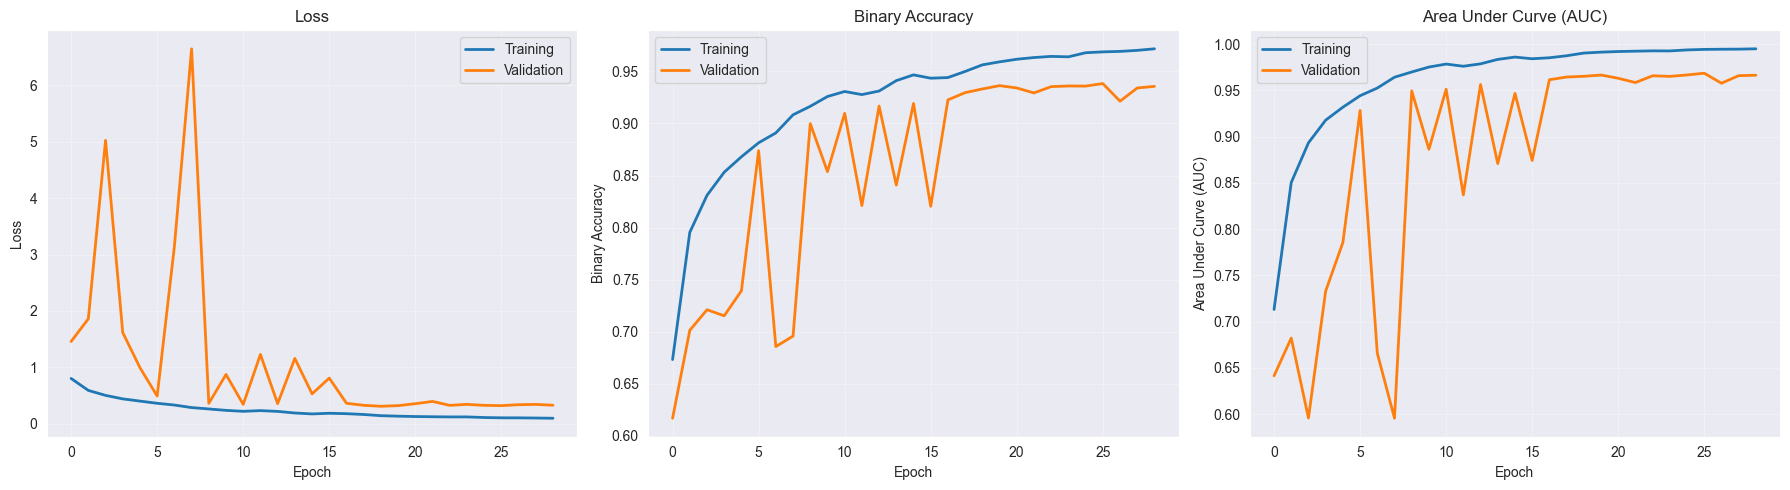

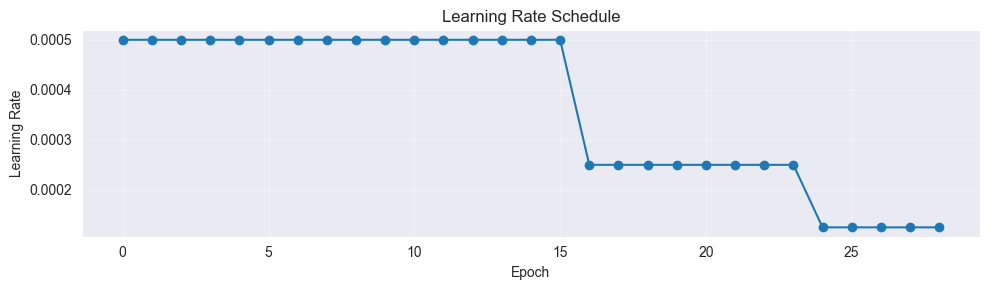

In [4]:
def plot_training_metrics(history_data):
    if history_data is None:
        print("No training history available")
        return

    metrics_list = ['loss', 'binary_accuracy', 'auc']
    titles = ['Loss', 'Binary Accuracy', 'Area Under Curve (AUC)']

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    for i, (metric, title) in enumerate(zip(metrics_list, titles)):
        if metric in history_data and f'val_{metric}' in history_data:
            axes[i].plot(history_data[metric], label='Training', linewidth=2)
            axes[i].plot(history_data[f'val_{metric}'], label='Validation', linewidth=2)
            axes[i].set_title(title)
            axes[i].set_xlabel('Epoch')
            axes[i].set_ylabel(title)
            axes[i].legend()
            axes[i].grid(True, alpha=0.3)
        else:
            axes[i].text(0.5, 0.5, f"{metric} data not available",
                      horizontalalignment='center', verticalalignment='center')

    plt.tight_layout()
    plt.show()

    # Display learning rate if available
    if 'learning_rate' in history_data:
        plt.figure(figsize=(10, 3))
        plt.plot(history_data['learning_rate'], 'o-')
        plt.title('Learning Rate Schedule')
        plt.xlabel('Epoch')
        plt.ylabel('Learning Rate')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

plot_training_metrics(history)

## 2. ROC Curve Analysis from Metrics

Since we have the metrics file with AUC values for each emotion, we can visualize these.

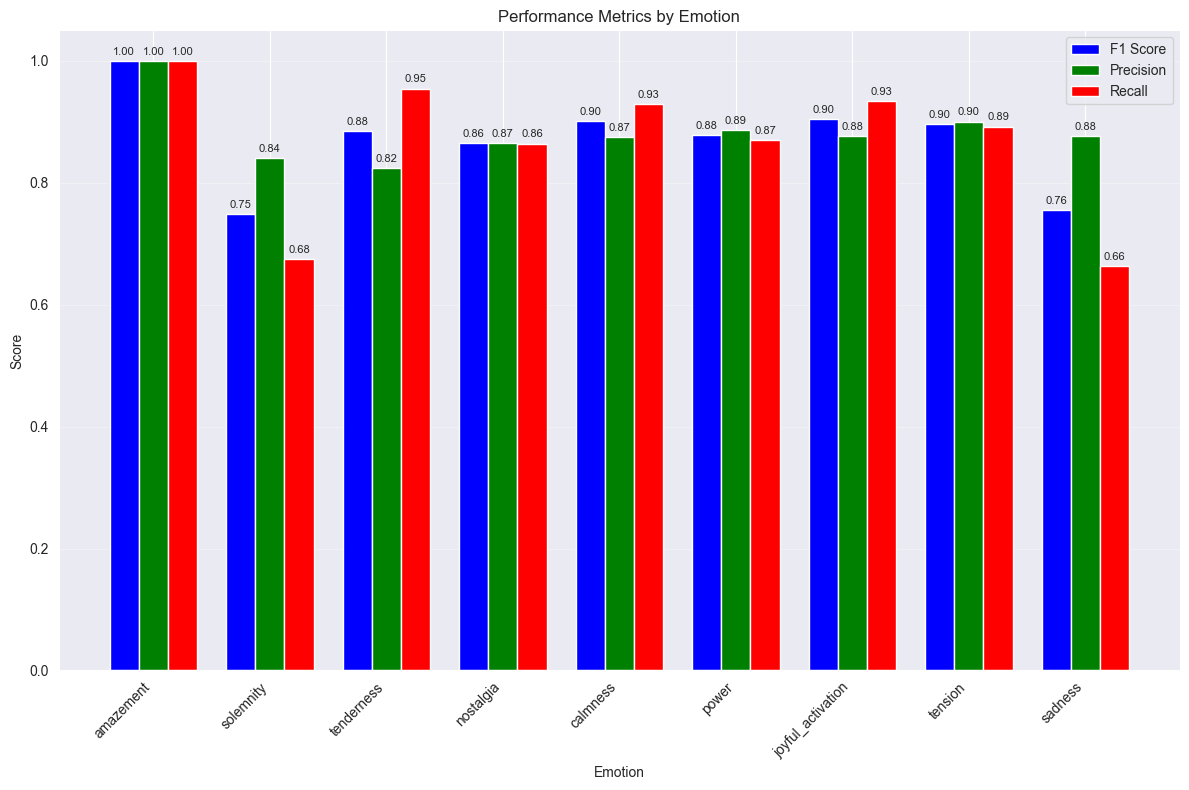

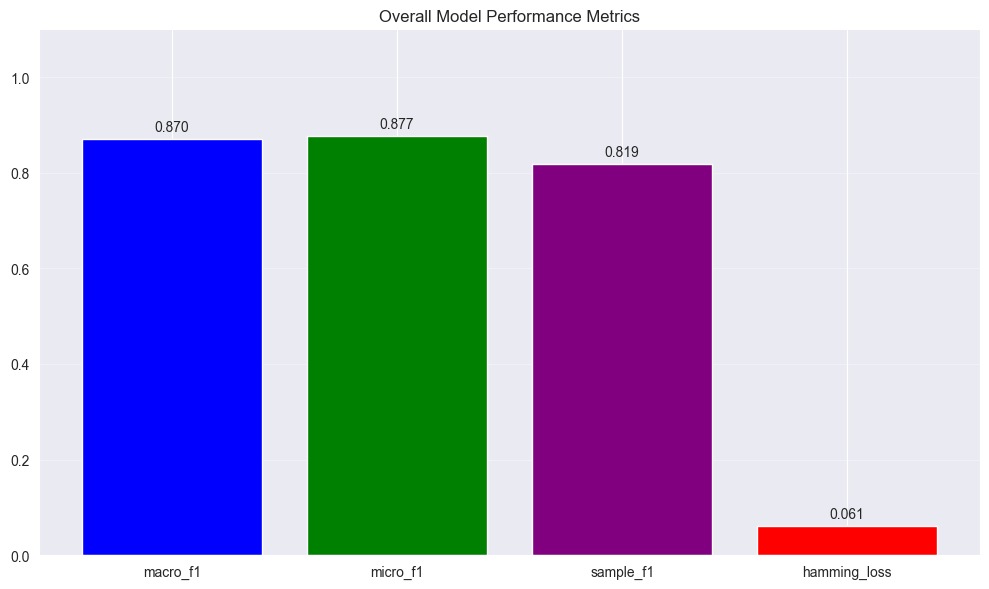

In [7]:
def visualize_auc_from_metrics(metrics_data):
    if metrics_data is None:
        print("No metrics data available")
        return

    # Extract emotion-specific AUC values
    emotion_metrics = {}
    for emotion in EMOTION_COLUMNS:
        if f"{emotion}_f1" in metrics_data:
            emotion_metrics[emotion] = {
                'f1': metrics_data.get(f"{emotion}_f1", 0),
                'precision': metrics_data.get(f"{emotion}_precision", 0),
                'recall': metrics_data.get(f"{emotion}_recall", 0)
            }

    # Plot F1, Precision, Recall for each emotion
    if emotion_metrics:
        fig, ax = plt.subplots(figsize=(12, 8))
        x = np.arange(len(emotion_metrics))
        width = 0.25

        # Create bars
        f1_bars = ax.bar(x - width, [emotion_metrics[e]['f1'] for e in emotion_metrics],
                         width, label='F1 Score', color='blue')
        precision_bars = ax.bar(x, [emotion_metrics[e]['precision'] for e in emotion_metrics],
                              width, label='Precision', color='green')
        recall_bars = ax.bar(x + width, [emotion_metrics[e]['recall'] for e in emotion_metrics],
                           width, label='Recall', color='red')

        # Add labels and legend
        ax.set_xlabel('Emotion')
        ax.set_ylabel('Score')
        ax.set_title('Performance Metrics by Emotion')
        ax.set_xticks(x)
        ax.set_xticklabels(list(emotion_metrics.keys()), rotation=45, ha='right')
        ax.legend()
        ax.grid(axis='y', alpha=0.3)

        # Add value labels on bars
        def add_labels(bars):
            for bar in bars:
                height = bar.get_height()
                ax.annotate(f'{height:.2f}',
                            xy=(bar.get_x() + bar.get_width() / 2, height),
                            xytext=(0, 3),
                            textcoords="offset points",
                            ha='center', va='bottom', fontsize=8)

        add_labels(f1_bars)
        add_labels(precision_bars)
        add_labels(recall_bars)

        plt.tight_layout()
        plt.show()

    # Plot overall metrics
    overall_metrics = ['macro_f1', 'micro_f1', 'sample_f1', 'hamming_loss']
    overall_values = [metrics_data.get(metric, 0) for metric in overall_metrics]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(overall_metrics, overall_values, color=['blue', 'green', 'purple', 'red'])

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom')

    plt.title('Overall Model Performance Metrics')
    plt.ylim(0, 1.1)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()


visualize_auc_from_metrics(metrics)

## 3. Emotion Correlation Analysis from Metrics

We'll analyze the patterns in emotion correlations by comparing precision, recall, and F1 scores across different emotions.

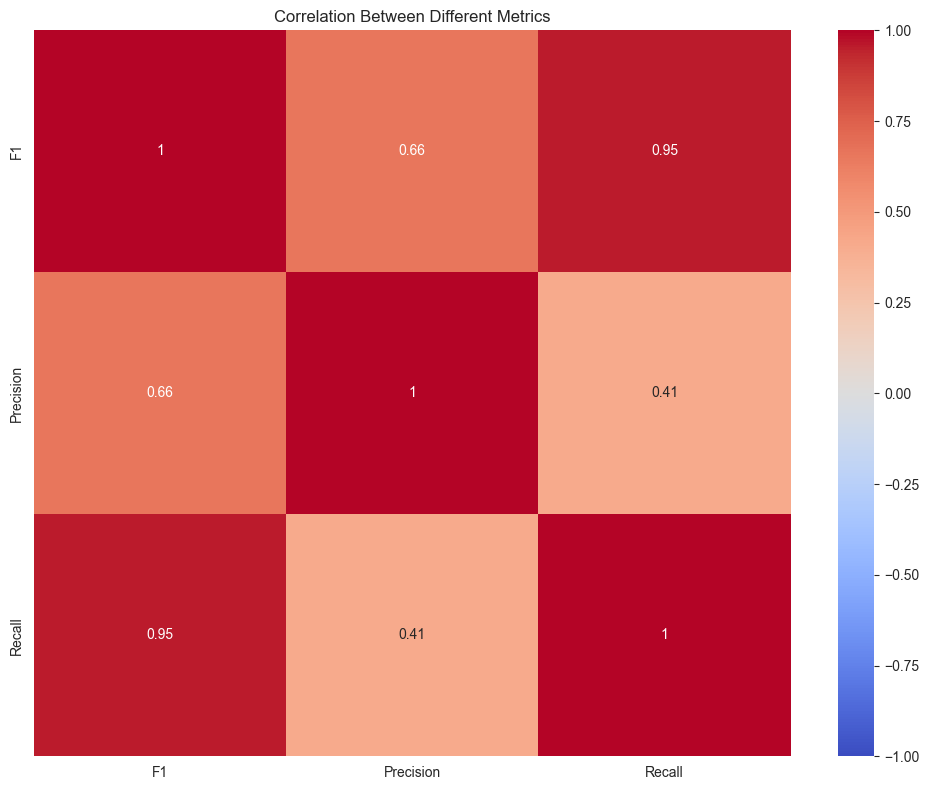

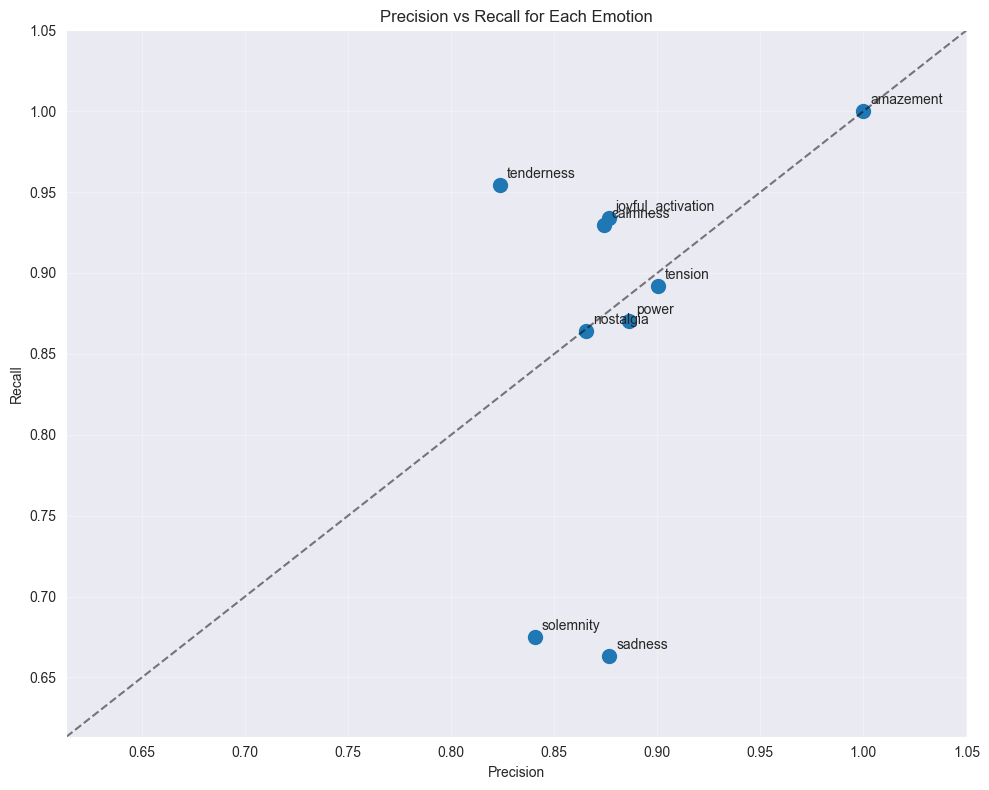


Emotion Performance Groups:
High Performers (F1 >= 0.916): amazement
Medium Performers (0.832 < F1 < 0.916): tenderness, nostalgia, calmness, power, joyful_activation, tension
Low Performers (F1 <= 0.832): solemnity, sadness

Precision-Recall Patterns:
Precision-Biased (P > R + 0.1): solemnity, sadness
Recall-Biased (R > P + 0.1): tenderness
Balanced (|P-R| <= 0.1): amazement, nostalgia, calmness, power, joyful_activation, tension


In [8]:
def analyze_emotion_correlations(metrics_data):
    if metrics_data is None:
        print("No metrics data available")
        return

    # Extract metrics for each emotion
    metrics_df = pd.DataFrame(index=EMOTION_COLUMNS)

    for emotion in EMOTION_COLUMNS:
        if f"{emotion}_f1" in metrics_data:
            metrics_df.loc[emotion, 'F1'] = metrics_data[f"{emotion}_f1"]
            metrics_df.loc[emotion, 'Precision'] = metrics_data[f"{emotion}_precision"]
            metrics_df.loc[emotion, 'Recall'] = metrics_data[f"{emotion}_recall"]

    # Calculate correlations between metrics
    corr_matrix = metrics_df.corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
    plt.title('Correlation Between Different Metrics')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 8))
    plt.scatter(metrics_df['Precision'], metrics_df['Recall'], s=100)

    for i, emotion in enumerate(metrics_df.index):
        plt.annotate(emotion,
                     (metrics_df['Precision'][i], metrics_df['Recall'][i]),
                     xytext=(5, 5), textcoords='offset points')

    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.title('Precision vs Recall for Each Emotion')
    plt.grid(True, alpha=0.3)

    min_val = min(metrics_df['Precision'].min(), metrics_df['Recall'].min()) - 0.05
    max_val = max(metrics_df['Precision'].max(), metrics_df['Recall'].max()) + 0.05
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5)

    plt.xlim(min_val, max_val)
    plt.ylim(min_val, max_val)
    plt.tight_layout()
    plt.show()

    if metrics_df.shape[0] > 0:
        f1_values = metrics_df['F1'].sort_values()
        f1_min, f1_max = f1_values.min(), f1_values.max()
        f1_range = f1_max - f1_min

        high_threshold = f1_max - f1_range/3
        low_threshold = f1_min + f1_range/3

        high_performers = metrics_df[metrics_df['F1'] >= high_threshold].index.tolist()
        medium_performers = metrics_df[(metrics_df['F1'] < high_threshold) &
                                     (metrics_df['F1'] > low_threshold)].index.tolist()
        low_performers = metrics_df[metrics_df['F1'] <= low_threshold].index.tolist()

        print("\nEmotion Performance Groups:")
        print(f"High Performers (F1 >= {high_threshold:.3f}): {', '.join(high_performers)}")
        print(f"Medium Performers ({low_threshold:.3f} < F1 < {high_threshold:.3f}): {', '.join(medium_performers)}")
        print(f"Low Performers (F1 <= {low_threshold:.3f}): {', '.join(low_performers)}")

        precision_biased = metrics_df[metrics_df['Precision'] > metrics_df['Recall'] + 0.1].index.tolist()
        recall_biased = metrics_df[metrics_df['Recall'] > metrics_df['Precision'] + 0.1].index.tolist()
        balanced = metrics_df[abs(metrics_df['Precision'] - metrics_df['Recall']) <= 0.1].index.tolist()

        print("\nPrecision-Recall Patterns:")
        print(f"Precision-Biased (P > R + 0.1): {', '.join(precision_biased)}")
        print(f"Recall-Biased (R > P + 0.1): {', '.join(recall_biased)}")
        print(f"Balanced (|P-R| <= 0.1): {', '.join(balanced)}")

analyze_emotion_correlations(metrics)